<a href="https://colab.research.google.com/github/helonayala/sysid/blob/main/grey_box_activity_2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solution - activity 2b

In [55]:
!pip install diffrax

In [56]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
from scipy.optimize import minimize
from tqdm.notebook import tqdm

from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, LinearInterpolation
from jax import random, grad, jit, vmap
from jax.flatten_util import ravel_pytree

# Set JAX to use 64-bit precision for better solver accuracy
jax.config.update("jax_enable_x64", True)

try:
    print(f"JAX is running on: {jax.devices()[0].platform.upper()}")
except IndexError:
    print("No JAX devices found.")

JAX is running on: GPU


In [57]:
def process_and_plot_mat_file(file_url):
    local_filename = os.path.basename(file_url)
    print(f"Downloading {file_url} as {local_filename}...")
    get_ipython().system(f"rm -f {local_filename}")
    get_ipython().system(f"wget -q -O {local_filename} '{file_url}'")

    if not os.path.exists(local_filename):
        print(f"Error: File '{local_filename}' not found after attempting download.")
        return None, None, None, None

    print(f"File '{local_filename}' downloaded successfully.")
    try:
        mat_data = scipy.io.loadmat(local_filename)
        time_data = mat_data['time'].reshape(-1, 1)
        u_data = mat_data['u'].reshape(-1, 1)
        y_data = mat_data['y'].reshape(-1, 1)
        return time_data, u_data, y_data
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None, None, None

# URL of the .mat file
file_url = 'https://github.com/helonayala/sysid/raw/refs/heads/main/data/randomStepSequence.mat'
time, u, y = process_and_plot_mat_file(file_url)

if time is not None:
    time = time.flatten()
    u = u.flatten()
    y = y.flatten()

    N = time.shape[0]
    Ts = time[1] - time[0]
    fs = 1 / Ts
    T = time[-1]
    print(f"N={N}, fs={fs}, T={T}, Ts={Ts}")

File 'randomStepSequence.mat' downloaded successfully.
N=8150, fs=10.0, T=814.9000000000001, Ts=0.1


In [58]:
# --- Neural Network Helper Functions (from JAX ANN example) ---

def random_layer_params(m, n, key, scale=1e-2):
  """A helper function to randomly initialize weights and biases for a dense layer."""
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

def init_network_params(sizes, key):
  """Initialize all layers for a fully-connected neural network with sizes "sizes"."""
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

# def relu(x):
#   return jnp.maximum(0, x)

def predict(params, inputs):
  """Neural network forward pass."""
  activations = inputs
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = jnp.tanh(outputs) # Changed from relu to tanh
    # activations = relu(outputs)

  final_w, final_b = params[-1]
  logits = jnp.dot(final_w, activations) + final_b
  return logits

# --- New Hybrid ODE Model ---

def hybrid_dc_motor_model_jax(t, w, args):
    """The ODE function combining physical terms and a neural network."""
    theta1, theta3, params_nn, u_interp = args
    u = u_interp.evaluate(t)

    # The NN models the nonlinear dynamics (e.g., friction)
    # It takes velocity (w) and input (u) as inputs
    nn_input = jnp.array([w])
    nn_output = predict(params_nn, nn_input)

    # The new dynamic equation: dw/dt = linear_terms + nn_output
    return theta1 * w + theta3 * u + nn_output[0]

term = ODETerm(hybrid_dc_motor_model_jax)

In [59]:
# --- Setup for Multiple Shooting ---
n_shots = 163
n_timesteps_per_shot = N // n_shots

t_shots = jnp.array(time.reshape(n_shots, n_timesteps_per_shot))
y_data = jnp.array(y.reshape(n_shots, n_timesteps_per_shot))
u_interpolation = LinearInterpolation(ts=time, ys=u)

# --- NN and Optimization Configuration ---
nn_layer_sizes = [1, 10, 10, 1]  # 2 inputs (w, u), 2 hidden layers of 10, 1 output
solver = Dopri5()

# --- Create Initial Guess and Parameter Structures ---
key = random.key(0)
initial_theta1 = -0.6
initial_theta3 = 7.0
initial_params_nn = init_network_params(nn_layer_sizes, key)
initial_w_shots = np.zeros(n_shots)

# Store the structure of the NN parameters for later unflattening
flat_initial_nn_params, params_nn_struct = ravel_pytree(initial_params_nn)
len_nn_params = len(flat_initial_nn_params)

# Create the full, flattened initial guess vector for the optimizer
initial_guess_np = np.concatenate([
    np.array([initial_theta1, initial_theta3]),
    np.array(flat_initial_nn_params),
    initial_w_shots
])

# --- JIT-compiled Objective and Constraint Functions ---
# **CORRECTION**: The factory pattern is removed to avoid JIT closure issues.
# The unflattening logic is now explicitly inside each jitted function.

@jit
def objective_jax_nn(decision_vars):
    # Manually unflatten parameters inside the jitted function
    theta1 = decision_vars[0]
    theta3 = decision_vars[1]
    params_nn = params_nn_struct(decision_vars[2:len_nn_params+2])

    w_initial_shots = decision_vars[len_nn_params+2:]

    def simulate_shot(t_shot, w0):
        saveat = SaveAt(ts=t_shot)
        args = (theta1, theta3, params_nn, u_interpolation)
        sol = diffeqsolve(term, solver, t0=t_shot[0], t1=t_shot[-1], dt0=Ts, y0=w0, saveat=saveat, args=args)
        return sol.ys.flatten()

    w_pred = vmap(simulate_shot)(t_shots, w_initial_shots)
    return jnp.sum((w_pred - y_data)**2)

@jit
def continuity_constraints_jax_nn(decision_vars):
    # Manually unflatten parameters inside the jitted function
    theta1 = decision_vars[0]
    theta3 = decision_vars[1]
    params_nn = params_nn_struct(decision_vars[2:len_nn_params+2])

    w_initial_shots = decision_vars[len_nn_params+2:]

    def get_end_state(t_shot, w0):
        args = (theta1, theta3, params_nn, u_interpolation)
        sol = diffeqsolve(term, solver, t0=t_shot[0], t1=t_shot[-1], dt0=Ts, y0=w0, args=args)
        return sol.ys[-1]

    w_end_of_shots = vmap(get_end_state)(t_shots[:-1], w_initial_shots[:-1])
    return w_end_of_shots - w_initial_shots[1:]

# --- Create JIT-compiled Gradient and Jacobian Functions ---
objective_grad_func_nn = jit(jax.value_and_grad(objective_jax_nn))
constraints_jac_func_nn = jit(jax.jacrev(continuity_constraints_jax_nn))

In [60]:
# --- Wrapper Functions for SciPy Optimizer ---

def obj_for_scipy(dv_np):
    val, grad = objective_grad_func_nn(jnp.array(dv_np))
    return np.array(val), np.array(grad)

def cons_for_scipy(dv_np):
    return np.array(continuity_constraints_jax_nn(jnp.array(dv_np)))

def cons_jac_for_scipy(dv_np):
    jac_jax = constraints_jac_func_nn(jnp.array(dv_np))
    return np.array(jac_jax) # SciPy can handle the jacobian structure directly

# --- Run Optimization ---

cons = ({'type': 'eq', 'fun': cons_for_scipy, 'jac': cons_jac_for_scipy})
max_iterations = 50 # Increased iterations for the more complex model

with tqdm(total=max_iterations, desc="Optimizing Hybrid Model") as pbar:
    def callback(xk):
        pbar.update(1)

    print("--- Running Optimization with Neural Network ---")
    result = minimize(
        obj_for_scipy,
        initial_guess_np,
        method='SLSQP',
        jac=True,
        constraints=cons,
        options={'maxiter': max_iterations, 'disp': False},
        callback=callback
    )

print("\nOptimization finished with status:", result.message)

Optimizing Hybrid Model:   0%|          | 0/50 [00:00<?, ?it/s]

--- Running Optimization with Neural Network ---

Optimization finished with status: Iteration limit reached


In [64]:
# --- Extract and Display Results ---

# Unflatten the final optimized parameters
theta1_est = result.x[0]
theta3_est = result.x[1]
params_nn_est = params_nn_struct(result.x[2:len_nn_params+2])

# Use the first identified shot state as the initial state for the full simulation
w0_est = result.x[len_nn_params+2]

print("\n--- Identification Results ---")
print(f"Estimated physical parameters: theta1 = {theta1_est:.4f}, theta3 = {theta3_est:.4f}")

# --- Time-Domain Validation Plot ---
final_args = (theta1_est, theta3_est, params_nn_est, u_interpolation)
final_sol = diffeqsolve(term, solver, t0=time[0], t1=time[-1], dt0=Ts, y0=w0_est,
                        saveat=SaveAt(ts=jnp.array(time)), args=final_args, max_steps=16384)
yhat = final_sol.ys.flatten()



--- Identification Results ---
Estimated physical parameters: theta1 = -4.6480, theta3 = 48.9264


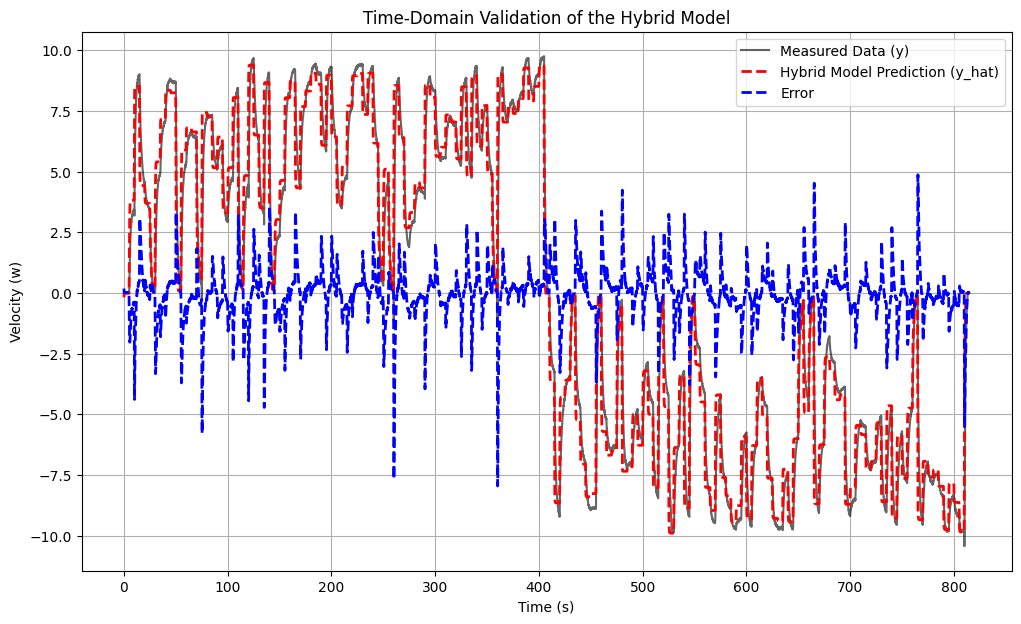

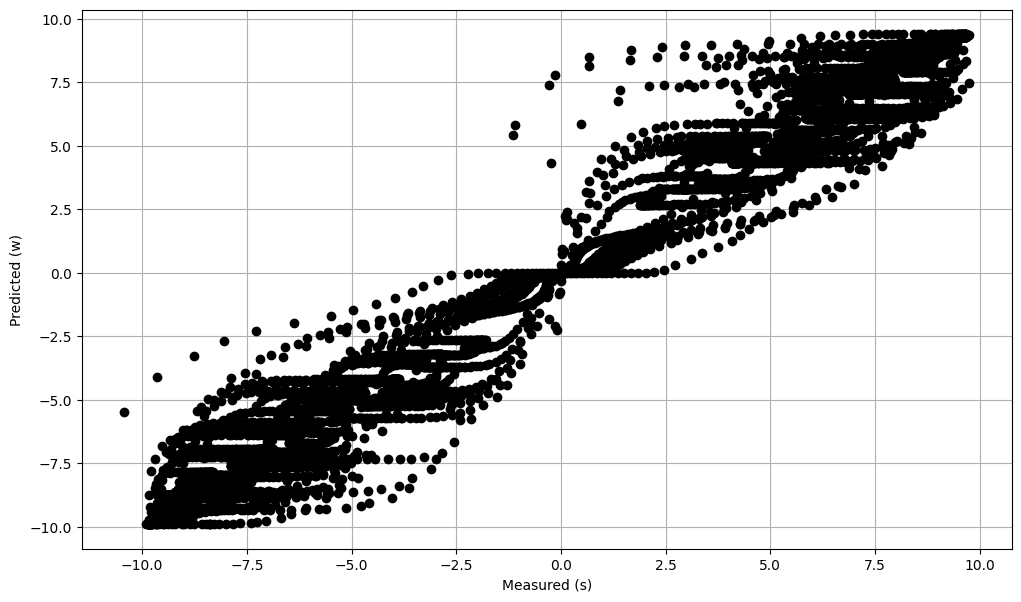

In [65]:
plt.figure(figsize=(12, 7))
plt.plot(time, y, 'k', label='Measured Data (y)', alpha=0.6)
plt.plot(time, yhat, 'r--', label='Hybrid Model Prediction (y_hat)', linewidth=2)
plt.plot(time, y - yhat, 'b--', label='Error', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Velocity (w)')
plt.title('Time-Domain Validation of the Hybrid Model')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 7))
plt.plot(y,yhat, 'ko')
plt.xlabel('Measured (s)')
plt.ylabel('Predicted (w)')
plt.grid(True)
plt.show()

### Friction Function Analysis

Here, we visualize the identified friction function. We plot the linear friction component against the total friction (linear + neural network). The neural network's contribution represents the learned nonlinearities. Since the NN friction depends on both velocity (`w`) and input (`u`), we plot it for the mean value of the input signal `u` to see its primary relationship with velocity.

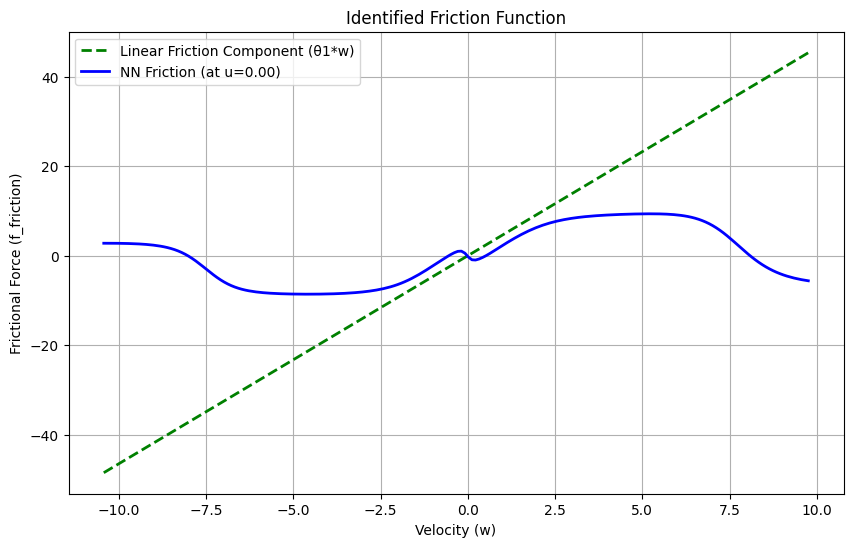

In [66]:
# --- Friction Function Plot ---

# Generate a range of velocity values for plotting
w_range = np.linspace(np.min(y), np.max(y), 200)

# Use the mean of the input signal as a representative value for u
u_mean = np.mean(u)

# 1. Linear friction component
f_linear = -theta1_est * w_range

# 2. Total friction (Linear + NN) component
# Vectorize the NN predict function for plotting
batch_nn_predict = vmap(predict, in_axes=(None, 1))
nn_inputs = jnp.array([w_range])
f_nn = batch_nn_predict(params_nn_est, nn_inputs).flatten()
f_total_friction = f_linear + f_nn

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(w_range, f_linear, 'g--', label='Linear Friction Component (θ1*w)', linewidth=2)
plt.plot(w_range, f_nn, 'b-', label=f'NN Friction (at u={u_mean:.2f})', linewidth=2)
plt.xlabel('Velocity (w)')
plt.ylabel('Frictional Force (f_friction)')
plt.title('Identified Friction Function')
plt.legend()
plt.grid(True)
plt.show()